<a href="https://colab.research.google.com/github/Timecapp/FourthAssignments/blob/main/shai_week10_speech_detector_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

**Dr. Shaista Hussain**
# MLE 10

# Hate Speech Detector

Today you are a machine learning engineer, a member of the Birdwatch at Twitter. 

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, a tweet contains hate speech if it has a racist or sexist sentiment associated with it. In other words, we need to classify racist or sexist tweets from other tweets.

A labelled dataset of 31,962 tweets (late 2017 to early 2018) is provided in the form of a compressed csv file with each line storing a tweet id, its label, and the tweet. Label '1' denotes the tweet is racist/sexist while label '0' denotes the tweet is not racist/sexist.

We will first approach the problem in a traditional approach: clean the raw text using simple regex (regular expression), extract features, build a naive Bayes models to classify tweets; then we build a deep learning model and explain our deep learning model with LIME.

## 📚 Learning Objectives

By the end of this lesson, you will be able to:

- Understand the basic concepts in natural language processing (NLP)
- Perform basic NLP tasks on text, e.g., tweets
- Build a naive Bayes classifier to detect hate speech 
- Build a bidirectional long short-term memory (BiLSTM) to detect hate speech
- Visualize embeddings with Tensorboard embedding projector
- Explain models with LIME

# Task I: Data Preprocessing


Data preprocessing is an essential step as it makes the raw text ready for mining, keeping input data clean and organized.

**1. Install dependencies.**

    Most modules are pre-installed in Colab, however, we need to update `gensim` to its recent version and install `lime`.

In [ ]:
#Import Resources and Utility
!pip install -U -q gensim==4.2.0 lime
import re # for regular expressions
import pandas as pd #for dataframe
import numpy as np #for numerics
import sklearn #for algorithms
import nltk #for language data
import os #for commands
from collections import Counter #for key value pairs and hashtags
import logging #for event logging
import time #for time management
import pickle #for byte streams
import itertools #for data for loops
import gensim #for semantic vectors
import wordcloud #for frequency visualizations
import tensorflow as tf #for neural networkds
import matplotlib.pyplot as plt #for visualizations
import seaborn as sns #for plots
import string #for ascii
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras for Neural network interfacing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk for text manipulation
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec for NLP
import gensim



**2. Connect Colab to your local Google Drive.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#mount drive to colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Use `pandas.read_csv` to load the tweets in `tweets.csv.gz` and save the `pd.DataFrame` into `raw`. Make sure the path points to where the data is located in your Google Drive. 

In [ ]:
#load dataframe as raw
raw = pd.read_csv('/content/drive/MyDrive/4thbrain/tweets.csv.gz')

In [ ]:
#view file
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


Confirmed data set uploaded

In [ ]:
#check stopwords download
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

4. Sample 5 random tweets from the dataset for each label and display `label` and `tweet` columns. 
Hint: one option is to use `sample()` followed by `groupby`. 

In [ ]:
# Colab includes an extension that renders pandas dataframes into interactive displays that can be filtered, sorted, and explored dynamically.
from google.colab import data_table
data_table.enable_dataframe_formatter() 

In [ ]:
# Sample 5 random tweets from each label
sampled_tweets = raw.groupby('label').sample(5)

# Display label and tweet columns
sampled_tweets[['label', 'tweet']].head()

,label,tweet
23464,0,@user if i make it to twelve ill be
18548,0,sunday: click on the link and like the page
26695,0,they are together happy enough !!#baby#kid#mom...
26464,0,#prayfororlando can we show #love &amp; not...
6569,0,aww yeah it's all good bing bong bing bong


5. The tweets are in English and all words should be already in lowercase. 
Now calculate the number of characters in each tweet and assign the values to a new column `len_tweet` in `raw`. 

In [ ]:
#Create new column 'len_tweet' to store the length of each tweet in characters
raw['len_tweet'] = raw['tweet'].apply(lambda x: len(x))

#Print new dataframe
print(raw)

          id  label                                              tweet  \
0          1      0   @user when a father is dysfunctional and is s...   
1          2      0  @user @user thanks for #lyft credit i can't us...   
2          3      0                                bihday your majesty   
3          4      0  #model   i love u take with u all the time in ...   
4          5      0             factsguide: society now    #motivation   
...      ...    ...                                                ...   
31957  31958      0  ate @user isz that youuu?ðððððð...   
31958  31959      0    to see nina turner on the airwaves trying to...   
31959  31960      0  listening to sad songs on a monday morning otw...   
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...   
31961  31962      0                   thank you @user for you follow     

       len_tweet  
0            102  
1            122  
2             21  
3             86  
4             39

6. What are the summary statistics of `len_tweet` for each label? 
Hint: use `groupby` and `describe`. 

In [ ]:
# Create a new column with the length of each tweet
raw['len_tweet'] = raw['tweet'].apply(lambda x: len(x))

# Group by label and get summary statistics
raw.groupby('label')['len_tweet'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,29720.0,84.328634,29.566484,11.0,62.0,88.0,107.0,274.0
1,2242.0,90.187779,27.375502,12.0,69.0,96.0,111.0,152.0


Note we have an imbalanced dataset: the ratio of non-hate speech to hate speech is roughly 13:1. 

7. Clean the tweets. 

    We use `re` to perform basic text manipulations. 
    Specically, remove anonymized user handle, remove numbers and special characters except hashtags.

8. Remove user handles from the text in `tweet`, or anything directly following the symbols `@`, and save the resulting tweets to a new column `tidy_tweet` in `raw`. 
    
    Hint: you can use `re.sub` on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tweet']`.

In [ ]:
# Remove anonymized user handles (e.g. @username)
raw['tweet'] = raw['tweet'].apply(lambda x: re.sub(r'@\w+', '', x))

# Remove numbers
raw['tweet'] = raw['tweet'].apply(lambda x: re.sub(r'\d+', '', x))

# Remove special characters except hashtags (#)
raw['tweet'] = raw['tweet'].apply(lambda x: re.sub(r'[^\w#]', '', x))

# Print the updated dataframe
print(raw)

          id  label                                              tweet  \
0          1      0  whenafatherisdysfunctionalandissoselfishhedrag...   
1          2      0  thanksfor#lyftcrediticantusecausetheydontoffer...   
2          3      0                                  bihdayyourmajesty   
3          4      0        #modeliloveutakewithuallthetimeinurðððððððð   
4          5      0                    factsguidesocietynow#motivation   
...      ...    ...                                                ...   
31957  31958      0                         ateiszthatyouuuðððððððððâï   
31958  31959      0  toseeninaturnerontheairwavestryingtowraphersel...   
31959  31960      0  listeningtosadsongsonamondaymorningotwtoworkissad   
31960  31961      1  #sikh#templevandalisedinin#calgary#wsocondemnsact   
31961  31962      0                               thankyouforyoufollow   

       len_tweet  
0            102  
1            122  
2             21  
3             86  
4             39

Displayed above is the updated dataframe

In [ ]:
# Create a new column with the cleaned tweets
raw['tidy_tweet'] = raw['tweet'].apply(lambda x: re.sub(r'@\w+', '', x))
raw.sample(5, random_state=203)
# Print the new dataframe 
print(raw)

          id  label                                              tweet  \
0          1      0  whenafatherisdysfunctionalandissoselfishhedrag...   
1          2      0  thanksfor#lyftcrediticantusecausetheydontoffer...   
2          3      0                                  bihdayyourmajesty   
3          4      0        #modeliloveutakewithuallthetimeinurðððððððð   
4          5      0                    factsguidesocietynow#motivation   
...      ...    ...                                                ...   
31957  31958      0                         ateiszthatyouuuðððððððððâï   
31958  31959      0  toseeninaturnerontheairwavestryingtowraphersel...   
31959  31960      0  listeningtosadsongsonamondaymorningotwtoworkissad   
31960  31961      1  #sikh#templevandalisedinin#calgary#wsocondemnsact   
31961  31962      0                               thankyouforyoufollow   

       len_tweet                                         tidy_tweet  
0            102  whenafatherisdysfunctio

9. Remove non-alphabetic characters yet keep symbols `#` from `tidy_tweet` and save the result in `tidy_tweet`. 
In other words, keep all 26 letters and `#`.

    Note: in some applications, punctuations, emojis, or whether the word is in all caps can be of use. 
    You shall decide whether to extract such features for the application and perform error analysis to gain insight. 

In [ ]:
raw['tidy_tweet'] = raw['tidy_tweet'].apply(lambda x: re.sub("[^A-Za-z#\s]+","",x))
raw.sample(5, random_state=203)

,id,label,tweet,len_tweet,tidy_tweet
790,791,1,andyoukeeptellingthatonlyaryansareallowedtorap...,109,andyoukeeptellingthatonlyaryansareallowedtorap...
21928,21929,0,whatmakesyou,25,whatmakesyou
25642,25643,0,â#nzdusdextendsrbnzledrallyhitsfreshyearhighne...,101,#nzdusdextendsrbnzledrallyhitsfreshyearhighnea...
20436,20437,0,imonamissiontoridealloftheanimals#teamchanlv#v...,91,imonamissiontoridealloftheanimals#teamchanlv#v...
22552,22553,0,thecolorofahumanskinmattersalottothesystemwhen...,88,thecolorofahumanskinmattersalottothesystemwhen...


10. Remove words that is shorter than 4 characters from the processed tweets.

    For example, 
      
    `i m on a mission to ride all of the animals #teamchanlv #vegas #lasvegas #funtimes`
      
    will be reduced to 
      
    `mission ride animals #teamchanlv #vegas #lasvegas #funtimes`


In [ ]:
raw['tidy_tweet'] = raw['tidy_tweet'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
raw.sample(5, random_state=203)

,id,label,tweet,len_tweet,tidy_tweet
790,791,1,andyoukeeptellingthatonlyaryansareallowedtorap...,109,andyoukeeptellingthatonlyaryansareallowedtorap...
21928,21929,0,whatmakesyou,25,whatmakesyou
25642,25643,0,â#nzdusdextendsrbnzledrallyhitsfreshyearhighne...,101,#nzdusdextendsrbnzledrallyhitsfreshyearhighnea...
20436,20437,0,imonamissiontoridealloftheanimals#teamchanlv#v...,91,imonamissiontoridealloftheanimals#teamchanlv#v...
22552,22553,0,thecolorofahumanskinmattersalottothesystemwhen...,88,thecolorofahumanskinmattersalottothesystemwhen...


11. Remove stopwords and perform text normalization. 
    
    We will use `stopwords` collection and `SnowballStemmer` in `nltk` for this task. Before doing so, we need to tokenize the tweets. 
    Tokens are individual terms or words, and tokenization is simply to split a string of text into tokens. 
    You can use [`str.split()`](https://docs.python.org/3/library/stdtypes.html#str.split) on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tidy_tweet']` and save the result into `tokenized_tweet`. 
    
    Check out some methods for the built-in type `str` [here](https://docs.python.org/3/library/stdtypes.html#string-methods).

In [ ]:
tokenized_tweet = raw['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [whenafatherisdysfunctionalandissoselfishhedra...
1    [thanksfor#lyftcrediticantusecausetheydontoffe...
2                                  [bihdayyourmajesty]
3                [#modeliloveutakewithuallthetimeinur]
4                    [factsguidesocietynow#motivation]
Name: tidy_tweet, dtype: object

12. Extract stop words and remove them from the tokens.

    Note: depending on the task / industry, it is highly recommended that one curate custom stop words. 

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [ ]:
assert any(word in tokenized_tweet for word in stop_words) == False

13. Create a new instance of a language specific [`SnowballStemmer`](https://www.nltk.org/api/nltk.stem.snowball.html), set the `language` to be "english"; see [how to](https://www.nltk.org/howto/stem.html). 

In [ ]:
#Create new language instances
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [ ]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

0    [whenafatherisdysfunctionalandissoselfishhedra...
1    [thanksfor#lyftcrediticantusecausetheydontoffe...
2                                  [bihdayyourmajesti]
3                [#modeliloveutakewithuallthetimeinur]
4                         [factsguidesocietynow#motiv]
Name: tidy_tweet, dtype: object

14. Lastly, let's stitch these tokens in `tokenized_tweet` back together and save them in `raw['tidy_tweet']`. 
Use [`str.join()`](https://docs.python.org/3/library/stdtypes.html#str.join) and `apply`.

In [ ]:
raw['tidy_tweet'] = tokenized_tweet.apply(lambda x: ' '.join([word for word in x]))
raw.head(5)

,id,label,tweet,len_tweet,tidy_tweet
0,1,0,whenafatherisdysfunctionalandissoselfishhedrag...,102,whenafatherisdysfunctionalandissoselfishhedrag...
1,2,0,thanksfor#lyftcrediticantusecausetheydontoffer...,122,thanksfor#lyftcrediticantusecausetheydontoffer...
2,3,0,bihdayyourmajesty,21,bihdayyourmajesti
3,4,0,#modeliloveutakewithuallthetimeinurðððððððð,86,#modeliloveutakewithuallthetimeinur
4,5,0,factsguidesocietynow#motivation,39,factsguidesocietynow#motiv


# Task 2. Wordcloud and Hashtag

In this task, we want to gain a general idea of what the common words were and how hashtags were used in tweets. 
We will create wordclouds and extract the top hashtags used in each label. 

1. Before doing so, out of caution of possible data leakage, split the `raw['tidy_tweet']` into training and test datasets in a stratified fashion, set the test size at .25 and random state as 42.
    
    Save the results into `X_train`, `X_test`, `y_train`, and `y_test`.

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(raw['tidy_tweet'], raw['label'], test_size=0.25, random_state=42, stratify=raw['label'])

In [ ]:
assert X_train.shape == y_train.shape == (23971, )
assert X_test.shape == y_test.shape == (7991,)

2. A word cloud is a cluster of words depicted in different sizes. 
The bigger the word appears, the more often it appears in the given text. 
It can offer an easy visual presentation to reveal the theme of a topic. 

    Function `plot_wordcloud` is provided to plot 50 most frequent words from the given text in the shape of twitter's logo. 
    You may need to replace the image path accordingly.

In [ ]:
from wordcloud import WordCloud
from PIL import Image

def plot_wordcloud(text:str) -> None:
    '''
    Plot a wordcloud of top 50 words from the input text
    masked by twitter logo
    '''
    mask = np.array(Image.open('/content/drive/MyDrive/4thbrain/twitter-mask.png'))
    wordcloud = WordCloud( 
        background_color='yellow', 
        random_state=42,
        max_words=50, 
        max_font_size=80, 
        mask = mask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

3. Visualize the wordcloud. 

    The function expects one long string. 
    Stitch all tidy tweets from training set and save the single string to `all_words`, then visualize the wordcloud for all the words.

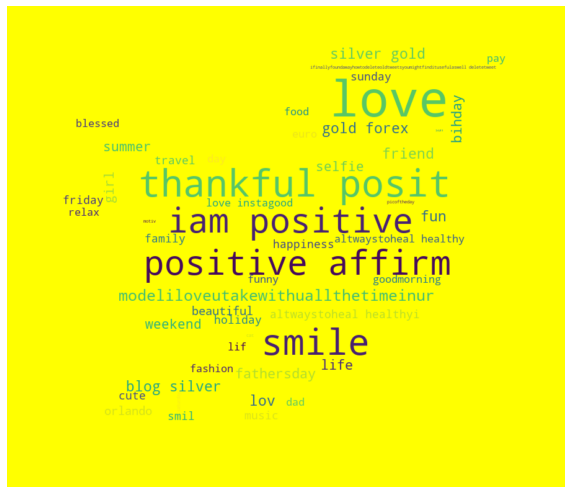

In [ ]:
# Concatenate the individual tweets into a single string
all_words = ' '.join(X_train)

# Visualize the wordcloud for all the words in the training set
plot_wordcloud(all_words)

4. Visualize the wordcloud just for the text from the tweets identified as hate speech. 

    Similarly, you need to stitch all the tidy tweets in training set that were identified as hate speech. 
    Save the long string to `negative_words`.

In [ ]:
hate = raw[raw['label']==1]
good = raw[raw['label']==0]

all_hate = ''.join(hate['tidy_tweet'])
all_good = ''.join(good['tidy_tweet'])

all_words = ''.join(raw['tidy_tweet'])


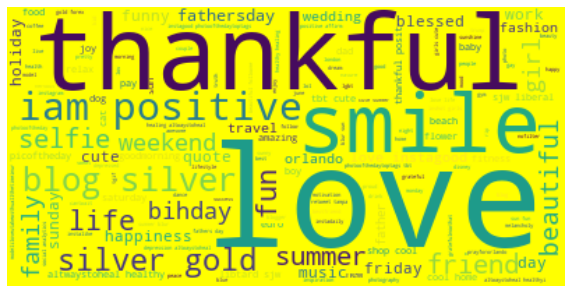

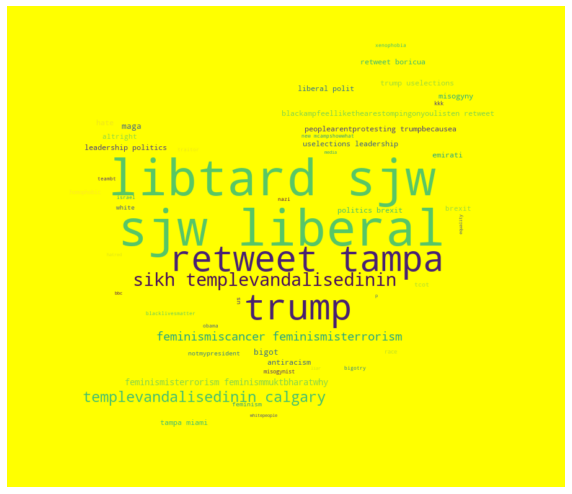

In [ ]:
# Initialize wordcloud object
wordcloud = WordCloud(background_color='yellow', random_state=42).generate(all_words)
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# Visualize the wordcloud for just the text from tweets identified as hate speech
plot_wordcloud(all_hate)

the second image above plots negative words

plotwordcloud() function to visualize the wordcloud just for the text from the tweets identified as hate speech, by passing the negativewords as an argument. This will generate a wordcloud in the shape of Twitter's logo containing only the words found in the tweets identified as hate speech.

5. Hashtag is a feature for tweets and we would like to inspect if hashtags provide information for our classification task. 

    Function `hashtag_extract` is provided to extract hastags from an iterable (list or series) and return the hashtags in a list. 

In [ ]:
def hashtag_extract(x) -> list:
    """
    extract hastags from an iterable (list or series) and 
    return the hashtags in a list.
    """
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

6. Extract hashtags from non-hate speech tweets.

In [ ]:
# Call the hashtag_extract function
HT_regular = hashtag_extract(good['tidy_tweet'])


In [ ]:
assert type(HT_regular) == list
assert type(HT_regular[0]) == list # nested list

7. Now extract hashtags from hate speech tweets.

In [ ]:
# Extract hashtags from hate speech tweets
HT_negative = hashtag_extract(hate['tidy_tweet'])

# Print out the list of hashtags
print(HT_negative)

[['cnncalls', 'michiganmiddleschoolbuildthewallchant', 'tcot'], ['australia', 'opkillingbay', 'seashepherd', 'helpcovedolphins', 'thecove', 'helpcovedolphin'], [], [], ['neverump', 'xenophobia'], ['love', 'peac'], [], ['race', 'identity', 'm'], ['altrightusesampinsecuritytoluremeninto', 'whitesupremaci'], ['linguisticsthatdoesntaddress', 'raceampracismisabout', 'power', 'raciolinguisticsbr'], ['brexit'], ['peoplearentprotesting', 'trumpbecausea', 'republicanwontheydosobecausetrumphasfuheredamp'], ['michelleobamaagorillabecauseracistshavelongthoughtofblackpeopleasnobet'], ['knicksgamesuckedmorethanhis', 'golf'], ['jewishsupremacist'], ['libtard', 'sjw', 'liberal', 'polit'], ['trashamericaivotedagainst', 'hateivotedagainstivotedagainstivot'], [], [], ['stereotyping', 'prejudiceofferno', 'hopeorsolutionsbutcreatethesameoldrepetitive', 'hate', 'conflict'], ['polspassedbyhowmanytimesandsaidnothing', 'bluelivesmatter', 'draintheswamp', 'ferguson'], ['thatmadeuscring'], ['antisemitism', 'hoco

In [ ]:
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

8. Both `HT_regular` and `HT_negative` are nested lists, so use the following trick to unnest both lists.

In [ ]:
assert type(HT_regular) == type(HT_negative) == list
assert type(HT_regular[0]) == type(HT_negative[0]) == str

9. Complete the function `top_hashtags` below to take a list of hashtags and return the top `n` hashtag keyword and its frequncy. 

In [ ]:
from typing import List, Tuple
from collections import Counter
def top_hashtags(hashtags:List[str], n=10) -> List[Tuple[str, int]]:
    ''' Function to return the top n hashtags '''
    
    a = Counter(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})

    d = d.nlargest(columns="Count", n=10)
    return d

1. Apply the function to the hashtag lists from the non-hate speech tweets and the hate speech tweets.

In [ ]:
top_hashtags(HT_regular)

,Hashtag,Count
33,love,1121
40,thankful,461
41,posit,457
188,fun,448
97,positive,416
98,affirm,412
223,smile,400
61,lov,355
96,iam,354
21,blog,343


In [ ]:
top_hashtags(HT_negative)

,Hashtag,Count
30,libtard,74
33,polit,74
31,sjw,73
32,liberal,73
67,retweet,63
156,trump,61
69,miami,44
68,tampa,32
209,sikh,26
210,templevandalisedinin,26


10. DISCUSS: are these hashtags making sense? should we include them as features or should we strip the # before tokenizing (that is, treat "#love" the same as "love")? why and why not?
          

> to gain insights into the topics of the tweets, then it would be beneficial to keep the hashtags as-is, as the # symbol provides context to the words that follow it and can be useful for understanding the topics being discussed. However, if you are looking to analyze the sentiment of the tweets, then it may be better to strip the # symbol before tokenizing, as the sentiment of a tweet should not differ depending on whether or not it contains a hashtag.

# Task 3. Features

Note that almost all the machine learning related Python modules expect numerical presentation of data; thus we need to transform our text first.
We will experiment with bag of words, tf-idf, and word2vec.  

1. Convert the collection of text documents to a matrix of token counts.

    Check the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 
    
    Create an instance of `CountVectorizer` named `bow_vectorizer`, set `max_features` to be `MAX_FEATURES`.
    Learn the vocabulary dictionary and return document-term matrix and save it to `bow_train`. Use `.fit_transform`. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
MAX_FEATURES = 1000

bow_vectorizer = CountVectorizer(max_features = MAX_FEATURES)
bow_train = bow_vectorizer.fit_transform(X_train)

In [ ]:
assert bow_train.shape == (X_train.shape[0], MAX_FEATURES)

2. Print the first three rows from `bow_train`. Hint: `.toarray()`.

In [ ]:
print(bow_train.toarray()[:3])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from scipy.sparse.csr import csr_matrix
assert type(bow_train) == csr_matrix

3. Similarly, convert the collection of text documents to a matrix of TF-IDF features.
    
    Create an instance of [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) named `tfidf_vectorizer`, set `max_features` to be `MAX_FEATURES`.

    Learn the vocabulary and idf, return document-term matrix and save it to `tfidf_train`. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
MAX_FEATURES = 1000

tfidf_vectorizer = TfidfVectorizer(max_features = MAX_FEATURES, stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')  # YOUR CODE HERE
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
assert type(tfidf_train) == csr_matrix
assert tfidf_train.shape == bow_train.shape == (X_train.shape[0], MAX_FEATURES)

4. Extract word embeddings using Word2Vec. 
We will use [`gensim`](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) for this task. 
    
    The Word2Vec model takes either a list of lists of tokens or an iterable that streams the sentences directly from disk/network. 
    Here, we tokenize the tidy tweets in `X_train` and save the list (`pd.series`) of lists of tokens to `tokenized_tweet`. 

In [ ]:
tokenized_tweet = X_train.apply (lambda x: x.split()) # tokenizing
assert tokenized_tweet.shape == X_train.shape

5. Import `Word2Vec` from `gensim.models`; see [doc](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). 

    Create a skip-gram `Word2Vec` instance named `w2v` that learns on the `tokenized_tweet`, with `vector_size` set at `MAX_FEATURES`, and other parameters are provided. 

In [ ]:
from gensim.models import Word2Vec

In [ ]:
MAX_FEATURES = 1000

w2v = Word2Vec(tokenized_tweet, vector_size=MAX_FEATURES, window=5, min_count=2, 
               sg=1, hs=0, negative=10, workers=2, seed=34)

6. Train the skip-gram model, set the epochs at 20.

In [ ]:
%%time
w2v.train(tokenized_tweet, total_examples = len(tokenized_tweet), epochs = 20)

CPU times: user 1.01 s, sys: 25.9 ms, total: 1.04 s
Wall time: 1.18 s


(57332, 479320)

7. Let's see how the model performs. 
Specify a word and print out the 10 most similar words from the our tweets in the training set. 
Use [`most_similar`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). 
Hint: print the type of `w2v` and `w2v.wv`.

In [ ]:
w2v.train.most_similar(positive="dinner")

AttributeError: ignored

In [ ]:
w2v.wv.most_similar(['good'])

KeyError: ignored

In [ ]:
w2v.wv.most_similar(positive='father')

KeyError: ignored

8. Discuss: how does w2v calculate the similarities? 

  YOUR ANSWER HERE

9. Discuss: do you think Word2Vec is supervised or unsupervised ML technique?

    YOUR ANSWER HERE

10. Engineer features. 

    For each tweet, we calculate the average of embeddings (function `word_vector`) and then apply it to every tidy tweet in `X_train` (use function `tokens_to_array`).
    Both functions are provided, inspect the code and save the features in `w2v_train`.

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

def word_vector(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += keyed_vec[word].reshape((1, size))
            count += 1
        except KeyError: 
            # handling the case where the token is not in vocabulary        
            continue
    if count != 0:
        vec /= count
    return vec

def tokens_to_array(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv):
    array = np.zeros((len(tokens), size))
    for i in range(len(tokens)):
        array[i,:] = word_vector(tokens.iloc[i], size, keyed_vec=keyed_vec)
    return array

In [ ]:
w2v_train = # YOUR CODE HERE

In [ ]:
assert w2v_train.shape == (X_train.shape[0], MAX_FEATURES)

11. Prepare the test data before modeling for each approach:


  - extract features from `X_test` using the bag of words approach; use `bow_vectorizer`
  - extract features from `X_test` using the tf-idf approach; use `tfidf_vectorizer`
  - extract features from `X_test` using Word2Vec embeddings; you need to first tokenized the tidy tweets in `X_test`, then convert the tokens to array of shape `(X_test.shape[0], MAX_FEATURES)`.

In [ ]:
bow_test = # YOUR CODE HERE
tfidf_test = # YOUR CODE HERE

tokenized_tweet_test = # YOUR CODE HERE
w2v_test = # YOUR CODE HERE

In [ ]:
assert bow_test.shape == tfidf_test.shape == w2v_test.shape == (X_test.shape[0], MAX_FEATURES)

# Task 4. Naive Bayes classifiers

In this task, you will build a [naive Bayes](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html) (here's another [ref](https://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn07-notes-nup.pdf)), classifiers to identify the hate speech tweets using different sets of features from the last task, and evaluate their performances. 

In the era of deep learning, naive Bayes is useful due to its simplicity and reasonable performance, especially if there is not much training data available. A common interview question is "Why is naive Bayes naive?". 

We will use multi-variate Bernoulli naive Bayes [`BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html); try other flavors of [naive Bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) if time permits. Code is pretty straightforward. 

1. Import `BernoulliNB` for modeling and `classification_report` for reporting performance. 

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

2. Create an instance of  `BernoulliNB` named `BNBmodel`. 

    We can use it for all three feature sets.

In [ ]:
# YOUR CODE HERE

3. Train the multi-variate Bernoulli naive Bayes using bag of words features and print the performance report.

In [ ]:
# YOUR CODE HERE (train the model)

In [ ]:
# YOUR CODE HERE (report)

4. Similarly, train the model using tf-idf features and print the performance report. 

    Is the performance expected? Why or why not?

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

5. Finally, train the model using Word2Vec embeddings and report the performance. 

In [ ]:
# YOUR CODE HERE
# YOUR CODE HERE

6. Discuss the differences in performace using tf-idf vs skim-gram embeddings. 

    YOUR ANSWER HERE

7. Examine a few tweets where the model(s) failed. 
What other features would you include in the next iteration?

    YOUR ANSWER HERE

# Task 5. Bidirectional LSTM 

In this task, you will build a bidirectional LSTM (BiLSTM) model to detect tweets identified as hate speech, and visualize the embedding layer using Tensorboard projector. 

Why BiLSTM? LSTM, at its core, preserves information from inputs that has already passed through it using the hidden state. Unidirectional LSTM only preserves information of the past because the only inputs it has seen are from the past. BiLSTMs run inputs in both ways, one from past to future and one from future to past and show very good results as they can understand context better [ref](https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm).

1. Tokenizing and padding. 
    
    As LSTM expects every sentence to be of the same length, in addition to [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) with a given number of vocabulary `VOCAB_SIZE`, we need to [pad](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) shorter tweets with 0s until the length is `MAX_LEN` and truncate longer tweets to be exact `MAX_LEN` long. 
    
   Function `tokenize_pad_sequences` is provided except that you need to supply correct `num_words` and `filters`; do NOT filter `#`. 
   
   We feed the processed `tidy_tweet` to `tokenize_pad_sequences`, but one can perform the preprocessing steps in `Tokenizer` and apply it directly on the raw tweets.

In [ ]:
VOCAB_SIZE = 25000  
MAX_LEN = 50

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def tokenize_pad_sequences(text):
    '''
    tokenize the input text into sequences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(
        num_words=# YOUR CODE HERE
        filters=# YOUR CODE HERE
        lower=True, split=' ', oov_token='oov')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=MAX_LEN)

    return X, tokenizer

In [ ]:
print('Before Tokenization & Padding \n', raw['tidy_tweet'][0])
X, tokenizer = tokenize_pad_sequences(raw['tidy_tweet'])
print('After Tokenization & Padding \n', X[0])
y = raw['label'].values

2. Let's split `X` into training and testing datasets, save 25% for testing. 
Then split training dataset into training and validation datasets, with 20% for validation. 
Set both `random_state` to be 42. 
Stratify both splits. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    # YOUR CODE HERE
    )
X_train, X_val, y_train, y_val = train_test_split(
    # YOUR CODE HERE
    )

In [ ]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

3. Now build a sequential model:

    - an embedding layer
    - a bidirectional LSTM with 32 units and set `return_sequences=True` in LSTM
    - a global average pooling operation for temporal data
    - a dropout layer with 20% rate
    - a dense layer of 32 units and set the activation function to be ReLu
    - a dense layer of 1 unit and set the proper activation function for classification

In [ ]:
from keras.models import Sequential
# YOUR CODE HERE (layer imports)

EMBEDDING_DIM = 16   
model = Sequential([
    # YOUR CODE HERE
])

In [ ]:
model.summary()

4. Compile the model. 

    Fill in a proper loss function and use adam as the optimizer. 
    For metrics, include precision and recall in the metrics, in addition to accuracy. 

In [ ]:
from keras.metrics import Precision, Recall
model.compile(
    loss=# YOUR CODE HERE
    optimizer='adam', 
    metrics=# YOUR CODE HERE]
    ) 

5. Train the model for 10 epochs on training dataset with a  validation set.

In [ ]:
EPOCHS=10
BATCH_SIZE = 32
history = model.fit(X_train, y_train,
                    validation_data=# YOUR CODE HERE
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

6. Function `plot_graphs` is provided below to visualize how the performance of model progresses as a function of epoch. 

    Visualize accuracy and loss. 

In [ ]:
def plot_graphs(history, metric):
  fig, ax = plt.subplots()
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  ax.set_xticks(range(EPOCHS))
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

7. The model starts to overfit after a couple of epochs. 
Consider using [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop training when a monitored metric has stopped improving. 

  What can we do to tame overfitting?

    YOUR ANSWER HERE

8. Print the classification report of the model on test dataset. 

In [ ]:
# YOUR CODE HERE

9. Discuss: how does the BiLSTM model improve the classification over naive Bayes? 

    YOUR ANSWER HERE

In [ ]:
# # NB using tf-idf
#               precision    recall  f1-score   support

#            0       0.96      0.97      0.97      7430
#            1       0.55      0.48      0.51       561

#     accuracy                           0.94      7991
#    macro avg       0.75      0.72      0.74      7991
# weighted avg       0.93      0.94      0.93      7991

# # NB using word2vec
#               precision    recall  f1-score   support

#            0       0.98      0.85      0.91      7430
#            1       0.29      0.82      0.43       561

#     accuracy                           0.85      7991
#    macro avg       0.64      0.83      0.67      7991
# weighted avg       0.94      0.85      0.88      7991

10. Visualize embeddings using [Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) in Tensorboard. 
The setup for Tensorboard can be tricky, most of the code is provided. 

    TensorBoard reads tensors and metadata from the logs of your tensorflow projects. 
    The path to the log directory is specified with log_dir below. 
    
    In order to load the data into Tensorboard, we need to save a training checkpoint to that directory, along with metadata that allows for visualization of a specific layer of interest in the model.

    Load the TensorBoard notebook extension and import `projector` from `tensorboard.plugins`.

In [ ]:
%load_ext tensorboard

In [ ]:
from tensorboard.plugins import projector

11. Clear any logs from previous runs if any.

In [ ]:
rm -rf /logs/  

12. Set up a logs directory, so Tensorboard knows where to look for data.

In [ ]:
import os
log_dir='/logs/tweets-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

13. Save the first `VOCAB_SIZE` most frequent words in the vocabulary as `metadata.tsv`.

In [ ]:
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  i = 0
  for label in tokenizer.word_index.keys():
    if label == 'oov':
      continue # skip oov
    f.write("{}\n".format(label))
    if i > VOCAB_SIZE:
      break
    i += 1

14. Save the weights we want to analyze as a variable. Note that the first value represents any unknown word, which is not in the metadata, here we will remove this value.

In [ ]:
weights = tf.Variable(model.layers[0].get_weights()[0][1:]) # `embeddings` has a shape of (num_vocab, embedding_dim) 

15. Create a checkpoint from embedding, the filename and key are the name of the tensor.

In [ ]:
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

16. Set up config.

In [ ]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

17. The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.

In [ ]:
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

18. Verify the following files exist under the current directory

In [ ]:
ls /logs/tweets-example/

19. Now run Tensorboard against on log data we just saved. 

    You may need to run this cell **twice** to see the projector correctly. 
    Use Chrome for least friction.

In [ ]:
%tensorboard --logdir /logs/tweets-example/

The TensorBoard Projector can be a great tool for interpreting and visualzing embedding. The dashboard allows users to search for specific terms, and highlights words that are adjacent to each other in the embedding (low-dimensional) space. Try a few word in the Search box and see if the embeddings make sense. 

# Task 6. Interpretation

Lastly let's try to understnad predictions by BiLSTM using a model agnostic approach -- [Local interpretable model-agnostic explanations (LIME)](https://christophm.github.io/interpretable-ml-book/lime.html)

1. Import `LimeTextExplainer` from the [`lime_text`](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_text) module in package [`lime`](https://github.com/marcotcr/lime)

In [ ]:
from lime.lime_text import LimeTextExplainer

2. Create an instance of `LimeTextExplainer`, call it `explanier`. 

In [ ]:
explainer = LimeTextExplainer(class_names=['no', 'yes'], random_state=2)

3. Method `explain_instance` expects the `classifier_fn` to be a function, we provide the function `predict_proba` as below. 

In [ ]:
def predict_proba(arr):
    processed = tokenizer.texts_to_sequences(arr)
    processed = pad_sequences(processed, padding='post', maxlen=MAX_LEN)
    pred = model.predict(processed)
    r = []
    for i in pred:
        temp = i[0]
        r.append(np.array([1-temp,temp])) 
    return np.array(r)

4. Read about [`explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance). 

    Create an instance named `exp` to explain the 16399th tidy tweet from the original dataset, i.e., `raw.tidy_tweet.iloc[16399]`. 

In [ ]:
idx = 16399 
exp = explainer.explain_instance(
    # YOUR CODE HERE
    num_features=6)
exp.show_in_notebook(text=raw.tidy_tweet.iloc[idx])

5. Pick another random tweet and generate explanations for the prediction.

In [ ]:
# YOUR CODE HERE

6. Jot down your observations in explaining the model. 

    YOUR ANSWER HERE

> # **Task 7. Rubric Questions & Answers**

*Algorithm Understanding*

**How does the Naive Bayes Classifier (NBC) work?**

> The NBC is a *probabilistic, classification* algorithm based on Bayes Theorem  

> naive: implies that the model features are independent of / unrelated to each other. 

> Bayes theorem provides a way of calculating posterior probability P(c|x) from P(c), P(x) and P(x|c)

> NBC calculates the posterior probability for each class. 
- The class with the highest posterior probability is the outcome of prediction.

**What is Posterior Probability?**

> Posterior Probability is a statistical expression of the likelihood of a true hypothesis, based on given data.  

Posterior = P(H|D)
where D = data and H = hypothesis
which is opposite to the likelihood function: P(D|H)

- Bayes theorem is the probability of a hypothesis being true; given observed data, and it relies on the use of likelihood P(D|H) alongside the prior P(H) and marginal likelihood P(D) in order to calculate the posterior P(H|D). 

*Interview Readiness*

**What is the difference between stemming and lemmatization in NLP?**

> Both stemmming and lemmatization are Text Normalization techniques. 

> The techniques prepare words, text, and documents for processing

> words are considered with respect to their roots (i.e. historical is from history); and the process of finding the root is text normalization (i.e. for inflected words).
- Lemma considers the context and converts the word to its meaningful base form,(i.e. an actual word), which is called Lemma.
- - uses corpus for stop words 
- - uses WordNet corpus to produce lemma.
- - requires that parts-of-speech are defined to produce the correct lemma.
- takes more time

vs. 

- Stemming does not require actual words
- - stemming is the process of removing the last few characters of a given word, to obtain a shorter form, even if that form doesn’t have any meaning.
- - getting base word is important to know whether the word is positive or negative -->Stemming is used to get that base word.
- - good for large datasets

- -  removes last few characters from a word, often leading to incorrect meanings and spelling.

**What is Word2Vec and how does it work?**

> W2V is an unsupervised model that generates vectors of the words 
- distributed numerical representations of word features – - these word features could comprise of words that represent the context of the individual words present in our vocabulary. 
- Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors.

- Can use either model architecture: 
- - Continuous Bag of Words (CBOW) model 
- - Skip-Gram model

> W2V lets you input unlabelled corpus, and the model will create dense word embeddings
> Word2Vec leverages a *supervised classification* model to get these embeddings from the corpus.

**When to use GRU over LSTM?**  

> Long Short Term Memory in short LSTM 
> - - RNN capable of learning long term sequences
> - - introduced by Schmidhuber &Hochreiter in 1997

> - - explicitly designed to avoid long term dependency problems. 

> - - Remembering the long sequences for a long period of time is its way of working. 

> - - at any moment, it is taking input from 3 different states (i.e.current input state, short term memory from the previous cell, and lastly the long term memory). 

> - - These cells use the gates/filters to regulate the information to be kept or discarded at loop (filters that discard unwatned info)operation before passing on the long term and short term information to the next cell.  

> - - total of three gates that LSTM uses as *Input Gate, Forget Gate, and Output Gate*. 

vs.

> Gated Recurrent Unit, GRU, incorporates the two gate operating mechanisms called Update gate and Reset gate. 

> GRU has two gates vs. LSTM has three gates

> GRU does not possess any internal memory, they don’t have an output gate that is present in LSTM

> the LSTM input gate and target gate are coupled by an update gate and in GRU reset gate is applied directly to the previous hidden state.

> LSTM reset gate is respnonsibility is taken by the two gates i.e., input and target. 

> GRU uses less training parameter, less memory; executes faster than LSTM 

> LSTM is more accurate on a larger dataset, good for large sequences and where accuracy is concerned, 

> GRU for when you have less memory consumption and want quicker results. 
 

# Acknowledgement & Reference

- DeepAI. Posterior Probability. 2023. https://deepai.org/machine-learning-glossary-and-terms/posterior-probability

- Lendave V. 2022. DEVELOPERS CORNER. LSTM Vs GRU in Recurrent Neural Network: A Comparative Study, AUGUST 28, 2021. https://analyticsindiamag.com/lstm-vs-gru-in-recurrent-neural-network-a-comparative-study/

- Ray, S. 2023. Naive Bayes Classifier Explained : Applications and Practice Problems of Naive Bayes Classifier, Modified On January 10th, 2023, https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

- Saumyab271. 2022. Stemming vs Lemmatization in NLP: Must-Know Differences, Saumyab271, July 1st, 2022, https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/#:~:text=Stemming%20v%2Fs%20Lemmatization&text=Stemming%20is%20a%20process%20that,form%2C%20which%20is%20called%20Lemma.

- Vatsal. 2021. Word2Vec Explained https://towardsdatascience.com/word2vec-explained-49c52b4ccb71


- Data is adapted from [Twitter sentiment analysis](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#ProblemStatement)
- [Twitter sentiment analysis](https://github.com/prateekjoshi565/twitter_sentiment_analysis/blob/master/code_sentiment_analysis.ipynb) 
- [Introduction to Word Embedding and Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)
- [When to use GRU over LSTM?](https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)
- Use a trained Word2Vec, Doc2Vec or FastTest embedding by `gensim` in buiding an embedding layers in Tensorflow, here's [how-to](https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow).